In [57]:
import numpy as np

In [58]:
def fourier_coeff(f_eval,  T):
    return np.fft.fft(f_eval, axis=0) * T / len(f_eval)

In [59]:
N = 9   # number of input functions n= 1, 2, ..., N
num_exp = 10 #number of times for each N (for avergaing error)


d = 2**13 # grid points

t_left = -.5
t_right = .5

T = t_right - t_left

t = np.linspace(t_left,t_right,d)
noise = .02


In [60]:
beta = 1.1 
gamma =  1.01
if gamma <=1:
    raise ValueError("gamma must be > 1")
eta = .25
alpha_sup = (2*beta -1 - gamma) / 2*(gamma + eta)
print("alpha_sup" , alpha_sup)
alpha = .9 * alpha_sup

if alpha <= 0 or alpha > 1:
    raise ValueError("alpha must be > 0 and < 1")

# lamb =  N ** (-  1  / (2* alpha + 2)) # regularization parameter

alpha_sup 0.11970000000000011


In [61]:
def sin_polin(t,alpha,M):
    return sum((2* np.sin(2*j*np.pi*t) / (j**alpha)) for j in range(1,M+2))

def fourier_expon(t,alpha,M):
    return sum((np.exp(1j*2*k*np.pi*t) / (k**alpha)) for k in range(1,M+2)) + sum((np.exp(1j*2*k*np.pi*t) / (k**alpha)) for k in range(-M,0))



#CHOOSE ground truth function and obs. noise         y_i = x_i * true_w + noise
sum_until = 30  # index M of truncation of the fourier series
true_w = sin_polin(t,beta,sum_until)                        

##fourier coefficients of w_true
true_w_coeff = fourier_coeff(true_w, T)  # normalized by the number of grid points

#for time-loc inputs
delta = 0.076

#for freq-loc inputs
L_max = sum_until


In [62]:
#To draw samples from the distribution rho_l = l^-beta

def power_law_samples(N, L, eta):
    """
    Generates N samples drawn from a power law probability distribution on the integers
    with exponent eta.
    
    Args:
    - N: an integer specifying the number of samples to generate
    -L: the samples are drawn in the interval [1,L+1]
    - eta: a positive float specifying the exponent of the power law
    
    Returns:
    - A numpy array of N integers drawn from the power law distribution
    """
    # Define the power law probability density function
    def p(x):
        return 1.0 / (x**eta)
    
    # Define the normalization constant
    Z = sum([p(l) for l in range(1, L+1)])
    
    # Generate the samples
    samples = []
    while len(samples) < N:
        # Choose a random integer in the range [1, L+1] with probability proportional to p(l)
        n = np.random.choice(range(1, L+1), p=[p(l)/Z for l in range(1, L+1)])
        samples.append(n)
    
    return np.array(samples)

In [63]:
#kernel coefficients

# kernel_coeff = np.zeros(t.size, dtype=complex)
# kernel_coeff[0] = 1
# for k in range(1,t.size):
#     kernel_coeff[k] = k**(-gamma) 

def kernel_fun(t,gamma,M):
    return 1 + sum((np.exp(1j*2*k*np.pi*t) / (k**gamma)) for k in range(1,M+1)) + sum((np.exp(1j*2*k*np.pi*t) / (np.abs(k)**gamma)) for k in range(-M,0))


def kernel_cosines(t,gamma,M):
    return 1 + sum((2* np.cos(2*k*np.pi*t) / (k**gamma)) for k in range(1,M+1)) 

M = sum_until

kerfun_eval = kernel_cosines(t,gamma, M)

kernel_coeff = fourier_coeff(kerfun_eval, T)
kernel_coeff = np.abs(kernel_coeff)   ## CHECK WHY YO NEED THIS

In [64]:
#prepare error arrays
error_sampmean = np.zeros(N)
error_sampstd = np.zeros(N)
error_logmea = np.zeros(N)
error_logstd = np.zeros(N)

In [65]:
#Inference and compute H errors
for n in range(1,N+1):
    
    error_of_exper = np.zeros(num_exp)
    
    for j in range(0,num_exp):
    

        #Localized in frequency
        #random vector for frequencies
        # L = power_law_samples(n, L_max, eta)

        # X =  np.array([ np.cos(l*t*2*np.pi) + 1j*np.sin(l*t*2*np.pi)  for l in L]).T

        
         #Localized in time
        R = np.random.normal(0,.25,n)

        X = np.array([np.where(((t-l) <= 2*delta) & ((t-l)>=0), 1, 0) for l in R]).T / (2*delta)
   
        # fourier coefficients of X, Y and true sol  
        X_fourier =  fourier_coeff(X,T)                                    #np.fft.fft(X, axis=0)  / d 

        #take the conjugate of the fourier coefficients of X
        X_fourier_conj = np.conj(X_fourier) 
        
        #Output data matrix 
        Y = np.zeros((d,n))   #noisy 
        for i in range(0,n):
            Y[:,i] = np.fft.ifft(d*(true_w_coeff)*(X_fourier[:,i])) +  noise  * np.random.normal(0,1,d) 

        Y_fourier = fourier_coeff(Y,T)                                    

        lamb =  1e-4 * n ** (-  1  / (2* alpha + 2))
        w_fourier = np.zeros(t.size, dtype=np.complex128)
        for l in range(t.size):
            eigenval = kernel_coeff[l] * (np.abs(X_fourier[l,:])**2).sum() / N
            term1 = kernel_coeff[l] / (eigenval + lamb)
            term2 = (X_fourier_conj[l,:] * Y_fourier[l,:]).sum() / N

            w_fourier[l] = term1 * term2

        w_diff_coeff = w_fourier - true_w_coeff
        error_h_squared = (np.abs(w_diff_coeff[:M])**2 / kernel_coeff[:M]).sum()

        error_of_exper[j] = error_h_squared 
    
    error_sampmean[n-1] = np.mean(error_of_exper)     #error_of_exp.sum() / num_exp
    error_sampstd[n-1] = np.std(error_of_exper)        #np.sqrt((np.square(error_of_exp - error_sampmean[n-1] )).sum() / (num_exp-1))
    error_logmea[n-1] = np.mean(np.log(error_of_exper))
    error_logstd[n-1] = np.std(np.log(error_of_exper))

/tmp/ipykernel_122520/2749713552.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[:,i] = np.fft.ifft(d*(true_w_coeff)*(X_fourier[:,i])) +  noise  * np.random.normal(0,1,d)


Text(0, 0.5, 'Error \\   $ \\parallel \\tilde{w} - w^* \\parallel_{\\mathcal{H}} ^2$')

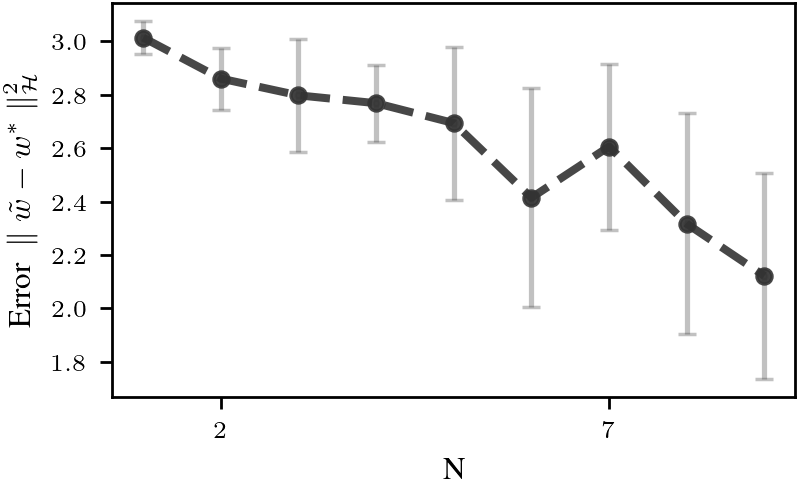

In [66]:
import matplotlib.pyplot as plt
from tueplots import  bundles
plt.rcParams.update({"figure.dpi": 250})
#define colors
red = np.array([141.0, 45.0, 57.0]) / 255.0
dark = np.array([51.0, 51.0, 51.0]) / 255.0
index = np.arange(1,N+1)

plt.rcParams.update(bundles.aistats2023())
fig, ax = plt.subplots(1,  )

ax.plot(index,error_sampmean,"o--",markersize=4.3, color=dark, alpha =.9,linewidth = 2.3)
ax.errorbar(index, error_sampmean, yerr =error_sampstd, color=dark, fmt='o', alpha=.3, capsize=2.5,ms=2)


# ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_xticks(index[1::5])
ax.set_ylabel(r'Error \   $ \parallel \tilde{w} - w^* \parallel_{\mathcal{H}} ^2$')
# ax.legend()
    


In [67]:
error_sampmean

array([3.01377392, 2.86052566, 2.79773815, 2.76833794, 2.69386122,
       2.41451081, 2.60596718, 2.31711726, 2.12176975])

/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


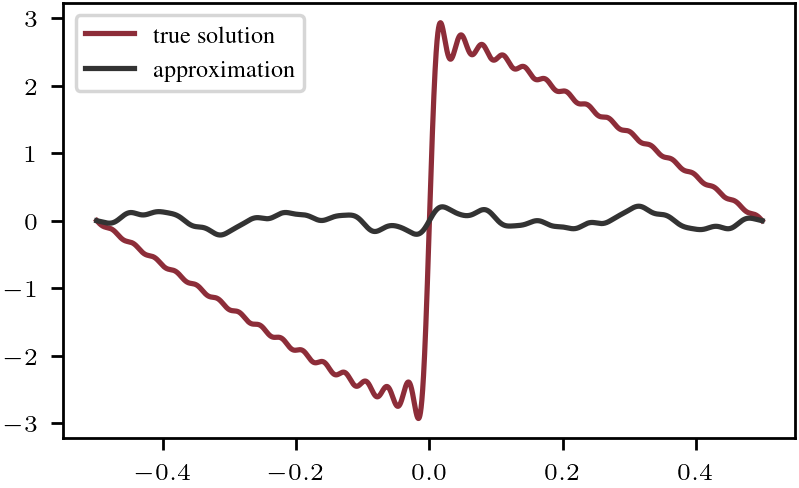

In [68]:
#plot true solution and w
w = np.fft.ifft(d* w_fourier)

fig, ax = plt.subplots(1, )
ax.plot(t, true_w, label='true solution', color = red)
ax.plot(t, w , label='approximation', color = dark)
ax.legend()